In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import functools as ft
from sklearn.model_selection import train_test_split
from PIL import Image
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score
from torch.utils.data.sampler import WeightedRandomSampler
from sklearn.metrics import confusion_matrix, classification_report
from pylab import rcParams
import torch.optim as optim
from google.colab import drive
import torchvision
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
import matplotlib.pyplot as plt
import torch

In [2]:
def plot_confusion(prediction, target, list_labels_cat):
    '''
    plot correlation's matrix to explore dependency between features 
    '''
    # init figure size
    targ_valids_cat = [list_labels_cat[i] for i in target]
    preds_valids_cat = [list_labels_cat[i] for i in prediction]
    rcParams['figure.figsize'] = 7, 7
    df = pd.DataFrame(confusion_matrix(targ_valids_cat, preds_valids_cat, labels = list_labels_cat, normalize='true'), index = list_labels_cat, columns= list_labels_cat)
    # df = pd.DataFrame(confusion_matrix(targ_valids_cat, preds_valids_cat, labels = list_labels_cat, normalize = 'true'))

    fig = plt.figure()
    sns.heatmap(df, annot=True, fmt=".2f")
    plt.show()
    fig.savefig('corr.png')



# Import features

In [3]:
drive.mount('/content/drive')
!ls

Mounted at /content/drive
drive  sample_data


# Understanding an image with Python

Our images are 250x250x3 numpy matrices

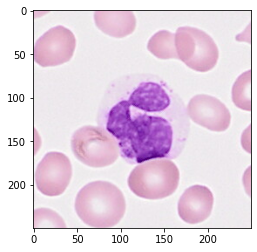

In [4]:
image = Image.open('/content/drive/MyDrive/TP_ML/allImages_247_282/image1.png').convert('RGB')
image = np.array(image)
plt.imshow(image)

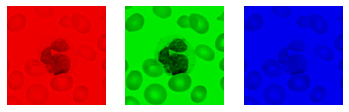

In [5]:
figure, plots = plt.subplots(ncols=3, nrows=1)
for i, subplot in zip(range(3), plots):
    temp = np.zeros(image.shape, dtype='uint8')
    temp[:,:,i] = image[:,:,i]
    subplot.imshow(temp)
    subplot.set_axis_off()
plt.show()

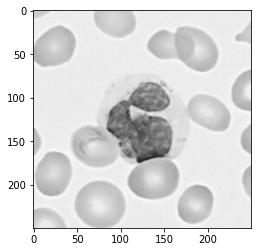

In [6]:
image_grey = Image.open('/content/drive/MyDrive/TP_ML/allImages_247_282/image1.png').convert('LA')
plt.imshow(image_grey)

# Images augmentation

1. Using transforms package, apply the following transformations to *image*:




*   Transform from image to tensor
*   Normalize image so that all pixel values are between 0 and 1, with 0.5 mean and 0.5 standard deviation
*   Crop image
*   Put a random horizontal flip
*   Jitter the colour of the image
*   Add a gaussian blur


Remark: you can use `transforms.Compose` to use several transformations at the same time.



## Convert image to tensor

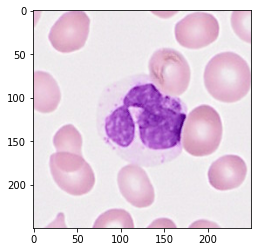

In [7]:
transforms1 = transforms.ToTensor()

plt.imshow(transforms1(image).permute(2,1,0))

## Normalize image

In [ ]:
transforms2 = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
plt.imshow(transforms2(image).permute(2,1,0))

## Crop image

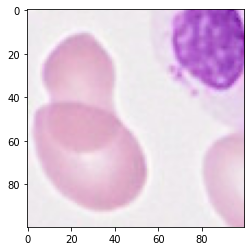

In [9]:
transforms3 = transforms.Compose([transforms.ToTensor(), transforms.RandomCrop(100, padding=None, pad_if_needed=False, fill=0)])
plt.imshow(transforms3(image).permute(2,1,0))

## Random Horizontal flip

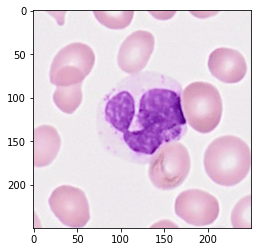

In [10]:
transforms4 = transforms.Compose([transforms.ToTensor(),  transforms.RandomHorizontalFlip(p=0.9)])
plt.imshow(transforms4(image).permute(2,1,0))

# Color jittering

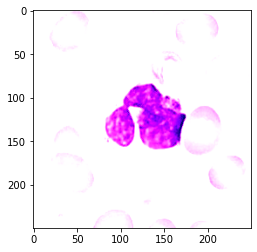

In [11]:
transforms5 = transforms.Compose([transforms.ToTensor(), transforms.ColorJitter(2,1)])
plt.imshow(transforms5(image).permute(2,1,0))

## Gaussian blur

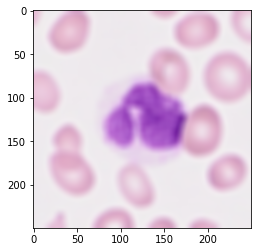

In [12]:
transforms6 = transforms.Compose([transforms.ToTensor(), transforms.GaussianBlur(11, sigma=5)])
plt.imshow(transforms6(image).permute(2,1,0))


# Add labels

In [13]:
labels = pd.read_csv('/content/drive/MyDrive/TP_ML/labels.csv')
labels

,Unnamed: 0,cytoID,label
0,0,628,NEUTROPHILES
1,1,468,NEUTROPHILES
2,2,55,NEUTROPHILES
3,3,464,NEUTROPHILES
4,4,541,BLASTES
...,...,...,...
3135,2012,2561,LYMPHOCYTES
3136,2013,2829,ERYTHROBLASTES
3137,2014,2591,NEUTROPHILES
3138,2015,2849,ERYTHROBLASTES


In [ ]:
labels['label'].value_counts()

ERYTHROBLASTES    1324
NEUTROPHILES       760
LYMPHOCYTES        357
ARTEFACTS          237
MONOCYTES          162
BLASTES             93
MYELOCYTES          78
BASOPHILES          69
METAMYELOCYTES      46
EOSINOPHILES         7
PROMYELOCYTES        7
Name: label, dtype: int64

## Labels encoding



2. a. Use the `LabelEncoder() `to convert categorical labels to numbers.

   b. Use `train_test_split` to split the dataset into 2 subdataframes `train` and `test` (test_size = 0.2, random_state = 42)


In [14]:
label_quality = LabelEncoder()
labels['label'] = label_quality.fit_transform(labels['label'])
labels

,Unnamed: 0,cytoID,label
0,0,628,9
1,1,468,9
2,2,55,9
3,3,464,9
4,4,541,2
...,...,...,...
3135,2012,2561,5
3136,2013,2829,4
3137,2014,2591,9
3138,2015,2849,4


In [15]:
classes = list(label_quality.classes_)
classes

['ARTEFACTS',
 'BASOPHILES',
 'BLASTES',
 'EOSINOPHILES',
 'ERYTHROBLASTES',
 'LYMPHOCYTES',
 'METAMYELOCYTES',
 'MONOCYTES',
 'MYELOCYTES',
 'NEUTROPHILES',
 'PROMYELOCYTES']

In [16]:
train,test = train_test_split(labels, test_size=0.2, random_state=42)

# Create dataloader

3. Create 2 dataloaders, `dataloader_train` and `dataloader_test` that would form the batches from train and test subdataframes respectively. Use a `batchsize` of 8 and `shuffle=True.`


Help:
You can first create a class `MyDataset` with: 

* 1 attribute: `dataframe`.
* 1 method: `__getitem__ (self, index)` that returns `X,y`, X being the transformed tensor image, and y the associated numerical label.

The tutorial below can provide you some guidance if needed:

https://androidkt.com/load-pandas-dataframe-using-dataset-and-dataloader-in-pytorch/




**Bonus**: Modify `MyDataset` to add the possibility of applying a transform to the image. 

In [17]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transform = None):
        self.dataframe = dataframe
        self.transform = transform
    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        transform = self.transform
        row = self.dataframe.iloc[index]
        sampleX, sampley = Image.open('/content/drive/MyDrive/TP_ML/allImages_247_282/image' + str(row['cytoID']) + '.png'), row["label"]
        if self.transform:
            sampleX = self.transform(sampleX)
            sampley = torchvision.torch.tensor(sampley)
        return sampleX, sampley


In [18]:
transform = transforms.Compose( # composing several transforms together
    [transforms.ToTensor()]) # to tensor object
    #  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # mean = 0.5, std = 0.5
    #  transforms.RandomCrop(32, padding=None, pad_if_needed=False, fill=0)])
    # transforms.RandomHorizontalFlip(p=0.5)])
    # transforms.ColorJitter(2,1)])
    # transforms.GaussianBlur(11, sigma=5)])

dataset_train = MyDataset(train, transform = transform)
dataset_test = MyDataset(test, transform = transforms.ToTensor())


In [19]:
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=10, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=10, shuffle=True)
batch = next(iter(dataloader_test))


## Visualization of a batch

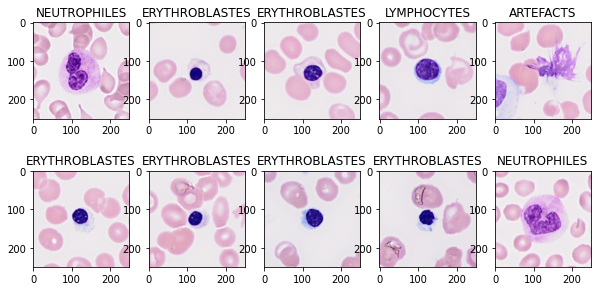

In [20]:

fig, axes = plt.subplots(2,5, figsize = ((10,5)))
for i, ax in enumerate(axes.flat):
    ax.imshow(batch[0][i].permute(2,1,0))
    ax.set_title(classes[batch[1][i].item()])

# Create a model from scratch

5. Create a model from scratch, composed of
* and encoder part with convolutional layers with relu activation, and pooling layers. 
* a classifier part with fully connected layers. 

You are free to decide of the architecture of your model.

Warning: the last layer must be composed of as many nodes as there are classes.

In [21]:
class Net(nn.Module):
    ''' Models a simple Convolutional Neural Network'''
    def __init__(self):
        ''' initialize the network '''
        super(Net, self).__init__()
	    # 3 input image channel, 6 output channels, 
	    # 5x5 square convolution kernel
        self.conv1 = nn.Conv2d(3, 6, 5)
	    # Max pooling over a (2, 2) window
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5) 
        self.fc1 = nn.Linear(55696, 120)# 5x5 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 11)

    def forward(self, x):
        ''' the forward propagation algorithm '''
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
        

In [24]:

net = Net()
net.cuda()

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=55696, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=11, bias=True)
)

Don't forget to enable the access to GPU in Edit / Notebook Settings


# Using a pretrained model

10. Now we will use a model that has been pretrained on ImageNet dataset. Create a new model by downloading `resnet50` from torch library, with using the option `pretrained = True`.

In [23]:
resnet = models.resnet50(pretrained=True)
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [25]:
resnet.cuda()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

11. Repeat 8 and 9 with your new model. What can you now tell about the pretrained model?


# Dealing with unbalanced classes

12. Even if results are getting better, underrepresented classes are still hard to classify. Create a new dataloader that would use a `WeightedRandomSampler` to make classes more balanced in every batch, and train again your model. 

Remark: the training will be slower on the overrepresented classes than before, you can use a larger epochs number (such as 10 or more).

What results do you observe?

In [26]:
from torch.utils.data.sampler import WeightedRandomSampler
y = train[['label']]

numDataPoints = 2512

class_sample_count = np.array(y.value_counts().sort_index())


weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in y['label']])

samples_weight = torch.from_numpy(samples_weight)

sampler = WeightedRandomSampler(samples_weight, len(samples_weight))

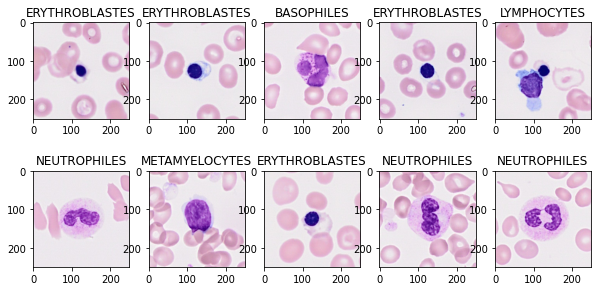

In [28]:
dataloader_train_weighted = torch.utils.data.DataLoader(dataset_train, batch_size=10, sampler = sampler)
dataloader_test_weighted = torch.utils.data.DataLoader(dataset_test, batch_size=10, shuffle=True)
batch = next(iter(dataloader_test_weighted))

fig, axes = plt.subplots(2,5, figsize = ((10,5)))
for i, ax in enumerate(axes.flat):
    ax.imshow(batch[0][i].permute(2,1,0))
    ax.set_title(classes[batch[1][i].item()])

13. Discuss about the overall results, compared with Machine Learning methods 
used in the first TP.